In [4]:
from mysql.connector import connect, errorcode, Error
from os import environ
import pandas as pd
from dotenv import load_dotenv
import json, time
import matplotlib.pyplot as plt
load_dotenv()

True

In [5]:
config = {
    "user": environ['DATABASE_USERNAME'],
    "password": environ['DATABASE_PASSWORD'],
    "host": environ['DATABASE_HOST'],
    "database": environ['DATABASE_NAME'],
    "charset": 'utf8'
}

In [6]:
def get_connection():
    try:
        print("Connecting to the database...\n config: ", config)
        return connect(**config)
    except Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
        return None

In [7]:
def get_data(connection: connect, query: str):
    my_cursor = connection.cursor()
    my_cursor.execute(query)
    data = my_cursor.fetchall()
    my_cursor.close()
    return data

In [73]:
cnx = get_connection()

print("Connection established")

data1k = get_data(cnx, "SELECT * FROM UN.VENTAS LIMIT 1000000")

df = pd.DataFrame(data1k, columns=['ID_VENTA', 'FECHA_VENTA', 'ID_CLIENTE', 'ID_EMPLEADO',
                  'ID_PRODUCTO', 'CANTIDAD', 'PRECIO_UNITARIO', 'DESCUENTO', 'FORMA_PAGO'])

cnx.close()

df.to_json("ventas.json", orient="records", lines=True)

df






Connecting to the database...
 config:  {'user': 'ed2studentsG6', 'password': 'd8d0274ccb39fcded4a5fac1961580104770fa93620f4a699cccecae58e8efe5', 'host': 'lab-ed.c9q48as80ych.us-east-1.rds.amazonaws.com', 'database': 'UN', 'charset': 'utf8'}
Connection established


,ID_VENTA,FECHA_VENTA,ID_CLIENTE,ID_EMPLEADO,ID_PRODUCTO,CANTIDAD,PRECIO_UNITARIO,DESCUENTO,FORMA_PAGO
0,00004df7-75ba-4693-b8a8-e7157fca6b35,2024-08-09,5476,810,1178,13,666.58,20.75,Transfer
1,00006952-8e9e-4f4a-871b-0c8a905d837c,2024-08-10,942,730,1577,16,259.38,39.74,Check
2,00006a1a-5bfd-4491-aec3-1bff92e28a77,2024-06-30,7299,339,456,8,617.91,0.27,Transfer
3,00006cc9-bee2-4b74-b32b-7a4d4ae0f175,2024-09-29,997,252,1050,14,829.02,43.88,Check
4,00007785-74c5-4e49-910e-415b2f1d9ae6,2024-09-12,7284,265,1260,4,407.57,8.31,Cash
...,...,...,...,...,...,...,...,...,...
999995,ffffd59c-0469-48f4-87fb-4713de691b15,2024-09-17,576,923,3483,8,257.07,3.67,Card
999996,ffffe4be-eb41-4e34-af1f-3eb18df35f2b,2024-09-08,9213,887,7,9,730.24,20.73,Card
999997,ffffe92e-99ca-4483-af3c-6882b4dfff47,2024-11-23,5739,907,2283,4,972.92,9.89,Card
999998,fffff9ae-429d-4892-9338-02d93667858c,2024-07-25,5756,122,2721,6,575.94,41.30,Card


In [74]:
export_times = {}

class fila:
    def __init__(self, ID_VENTA, FECHA_VENTA, ID_CLIENTE, ID_EMPLEADO,ID_PRODUCTO, CANTIDAD, PRECIO_UNITARIO, DESCUENTO, FORMA_PAGO):
        self.id_cliente = ID_CLIENTE
        self.fecha_venta = FECHA_VENTA
        self.id_venta = ID_VENTA
        self.id_empleado = ID_EMPLEADO
        self.id_producto = ID_PRODUCTO
        self.cantidad = CANTIDAD
        self.precio_unitario = PRECIO_UNITARIO
        self.descuento = DESCUENTO
        self.forma_pago = FORMA_PAGO
        
with open('ventas.json', 'r', encoding='utf-8') as file:
    lista_objetos_general=[]
    for line in file:

        venta = json.loads(line)

        id_venta = venta["ID_VENTA"]
        fecha = venta["FECHA_VENTA"]
        cliente = venta["ID_CLIENTE"]
        empleado = venta["ID_EMPLEADO"]
        producto = venta["ID_PRODUCTO"]
        cantidad = int(venta["CANTIDAD"])
        precio_unitario = float(venta["PRECIO_UNITARIO"])
        descuento = float(venta["DESCUENTO"])
        forma_pago = venta["FORMA_PAGO"]

        lista_objetos_general.append(fila(id_venta,fecha,cliente,empleado,producto,cantidad,precio_unitario,descuento,forma_pago))

def promedio(diccionario_total,promedios):
    for clave in diccionario_total[0].keys():
        suma = 0
        for j in range(5):
            suma += diccionario_total[j][clave]
        promedio = suma / 5
        promedios[clave] = promedio

def graficador(ordenamiento,nombre):
    # Ejes X e Y
    x = list(ordenamiento.keys())
    y = list(ordenamiento.values())

    # Crear gráfica
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, color='blue', linewidth=1)

    # Títulos y etiquetas
    plt.title("Tiempos de ejecución por número de elementos")
    plt.xlabel("Número de elementos")
    plt.ylabel("Tiempo (segundos)")

    # Mostrar gráfica
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{nombre}.png")
    
def rearmarJSON(lista_a_usar,metodo):
    ventas_dict_list = []
    for v in lista_a_usar:
        ventas_dict_list.append({"ID_VENTA": v.id_venta,"FECHA_VENTA": v.fecha_venta,"ID_CLIENTE": v.id_cliente,"ID_EMPLEADO": v.id_empleado,"ID_PRODUCTO": v.id_producto,"CANTIDAD": v.cantidad,"PRECIO_UNITARIO": v.precio_unitario,"DESCUENTO": v.descuento,"FORMA_PAGO": v.forma_pago})
    with open(f"{metodo}.json", "w") as archivo_json:
        json.dump(ventas_dict_list, archivo_json, indent=4)



{0: 3.8051605224609374e-05, 10000: 2.2125343799591066, 20000: 7.335932445526123, 30000: 14.749385118484497, 40000: 25.374461603164672, 50000: 40.5628523349762, 60000: 65.1413432598114, 70000: 88.58930916786194, 80000: 110.67685942649841, 90000: 138.50565547943114, 100000: 147.05930795669556}


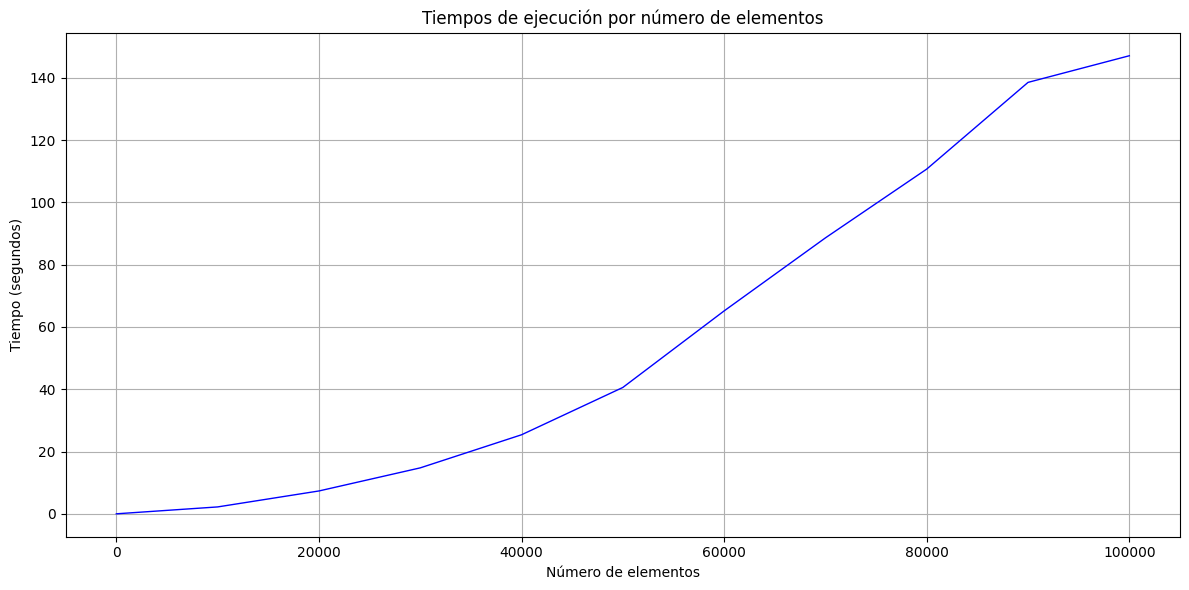

In [86]:
def insertion(lista):
    for i in range(1, len(lista)):
        actual = lista[i]
        j = i - 1
        while j >= 0 and lista[j].cantidad > actual.cantidad:
            lista[j + 1] = lista[j]
            j -= 1
        lista[j + 1] = actual
    return lista

#Insercion   
def tiempo_insercion():
    diccionario_total={}
    for j in range(5):
        diccionario={}
        r=0
        lista_objetos_tipo_fila=[]
        for i in range(0,100001,10000):
            while(r<=i):
                lista_objetos_tipo_fila.append(lista_objetos_general[r]) 
                r+=1
            lista_a_usar=lista_objetos_tipo_fila
            start = time.time()
            insertion(lista_a_usar)
            stop= time.time()
            diccionario[i]=stop-start
            
        diccionario_total[j]=diccionario
    Insercion={}
    promedio(diccionario_total,Insercion)
    graficador(Insercion,"Insercion")
    rearmarJSON(lista_a_usar,"Insercion")
    return Insercion

Insercion=tiempo_insercion()
print(Insercion)

In [76]:
def bubble_sort(lista):
    n = len(lista)
    for i in range(n):
        for j in range(0, n - i - 1):
            if lista[j].cantidad > lista[j + 1].cantidad:
                lista[j], lista[j + 1] = lista[j + 1], lista[j]
    return lista

def tiempo_bubble_sort():
    diccionario_total={}
    for j in range(5):
        diccionario={}
        r=0
        lista_objetos_tipo_fila=[]
        for i in range(1000):
            while(r<=i):
                lista_objetos_tipo_fila.append(lista_objetos_general[r]) 
                r+=1
            lista_a_usar=lista_objetos_tipo_fila
            start = time.time()
            bubble_sort(lista_a_usar)
            stop= time.time()
            diccionario[i]=stop-start
            
            
        diccionario_total[j]=diccionario
    Bubble_sort={}
    promedio(diccionario_total,Bubble_sort)
    graficador(Bubble_sort,"Bubble_Sort")
    rearmarJSON(lista_a_usar,"Bubble_Sort")
    return Bubble_sort

#Bubble_sort=tiempo_bubble_sort()
#print(Bubble_sort)

{0: 5.0067901611328125e-06, 10000: 0.0015110492706298829, 20000: 0.002146625518798828, 30000: 0.0033858299255371095, 40000: 0.004591226577758789, 50000: 0.005635738372802734, 60000: 0.00701594352722168, 70000: 0.007879495620727539, 80000: 0.009453201293945312, 90000: 0.011474609375, 100000: 0.013973188400268555}


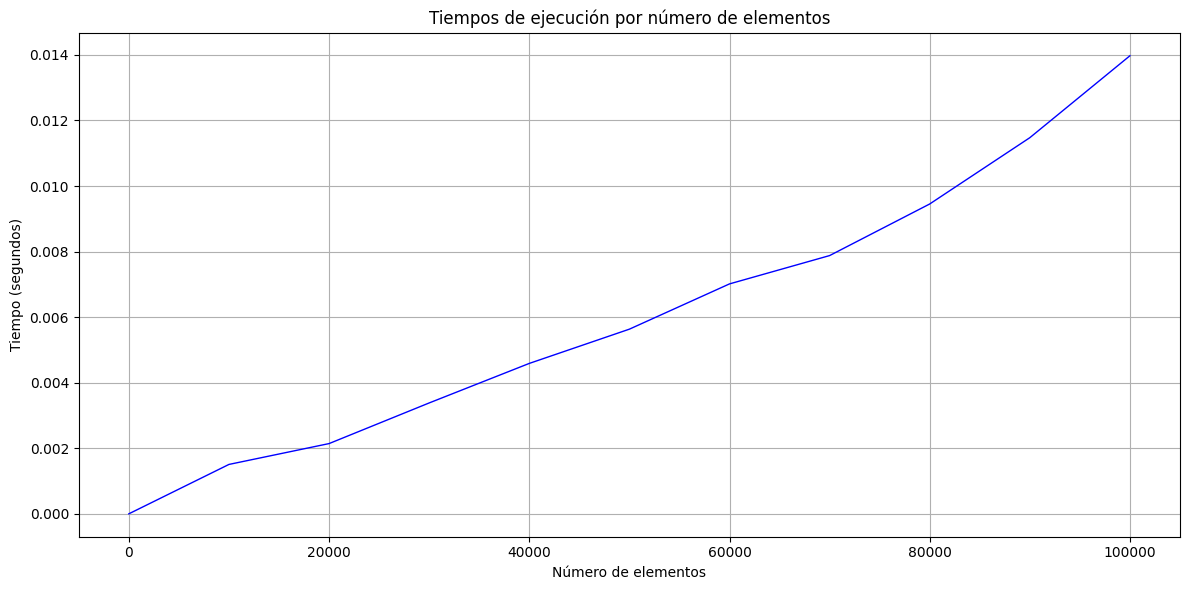

In [ ]:
def counting_sort(lista):
    if not lista:
        return lista

    max_cantidad = max(obj.cantidad for obj in lista)
    min_cantidad = min(obj.cantidad for obj in lista)

    rango = max_cantidad - min_cantidad + 1
    count = [[] for _ in range(rango)]

    for obj in lista:
        count[obj.cantidad - min_cantidad].append(obj)

    resultado = []
    for bucket in count:
        resultado.extend(bucket)

    return resultado

def tiempo_counting_sort():
    diccionario_total={}
    for j in range(5):
        diccionario={}
        r=0
        lista_objetos_tipo_fila=[]
        for i in range(0,200001,10000):
            while(r<=i):
                lista_objetos_tipo_fila.append(lista_objetos_general[r]) 
                r+=1
            lista_a_usar=lista_objetos_tipo_fila
            start = time.time()
            counting_sort(lista_a_usar)
            stop= time.time()
            diccionario[i]=stop-start
            
        diccionario_total[j]=diccionario
    Counting_sort={}
    promedio(diccionario_total,Counting_sort)
    graficador(Counting_sort,"Counting_sort")
    rearmarJSON(lista_a_usar,"CountingSort")
    return Counting_sort

Counting_sort=tiempo_counting_sort()
print(Counting_sort)

{0: 1.33514404296875e-06, 10000: 0.012818479537963867, 20000: 0.028177356719970702, 30000: 0.04644198417663574, 40000: 0.06446318626403809, 50000: 0.08547134399414062, 60000: 0.11370415687561035, 70000: 0.13606748580932618, 80000: 0.16305994987487793, 90000: 0.18749823570251464, 100000: 0.2074007511138916}


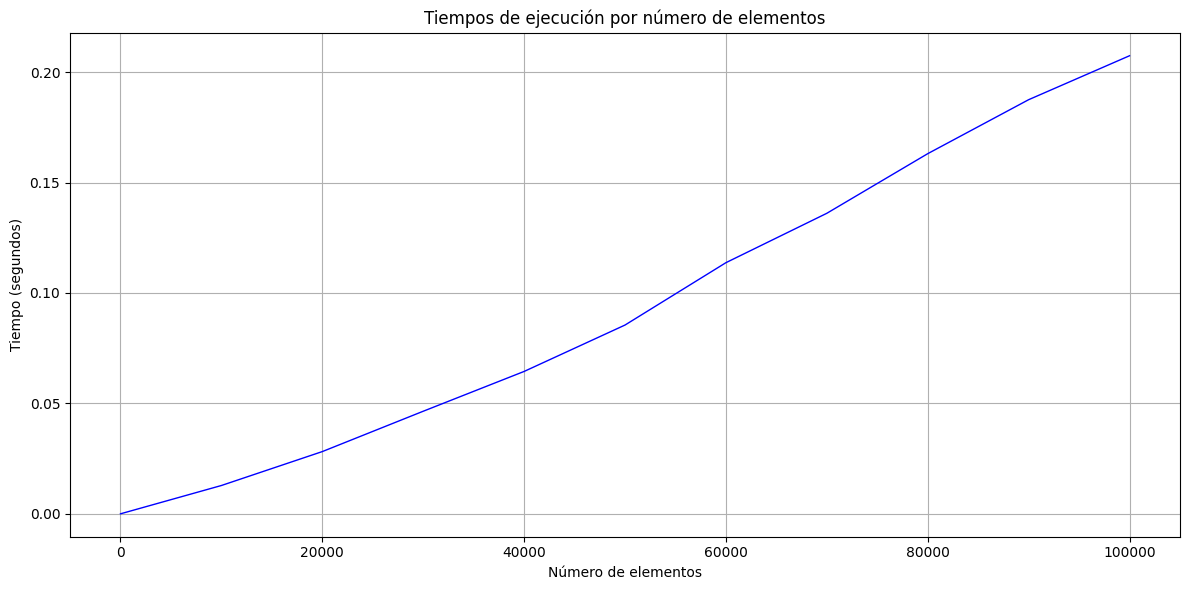

In [85]:
def partition(array, low, high):
    pivot = array[(low + high) // 2].cantidad
    i = low
    j = high
    while i <= j:
        while array[i].cantidad < pivot:
            i += 1
        while array[j].cantidad > pivot:
            j -= 1
        if i <= j:
            array[i], array[j] = array[j], array[i]
            i += 1
            j -= 1
    return i, j  # Devolvemos ambos índices para saber los límites

def quick_sort_iterative(array):
    stack = [(0, len(array) - 1)]
    while stack:
        low, high = stack.pop()
        if low < high:
            i, j = partition(array, low, high)
            if low < j:
                stack.append((low, j))
            if i < high:
                stack.append((i, high))
                
def tiempo_quick_sort():
    diccionario_total={}
    for j in range(5):
        diccionario={}
        r=0
        lista_objetos_tipo_fila=[]
        for i in range(0,100001,10000):
            while(r<=i):
                lista_objetos_tipo_fila.append(lista_objetos_general[r])
                r+=1
            lista_a_usar=lista_objetos_tipo_fila
            start = time.time()
            quick_sort_iterative(lista_a_usar)
            stop= time.time()
            diccionario[i]=stop-start
            
        diccionario_total[j]=diccionario
    Quick_sort={}
    promedio(diccionario_total,Quick_sort)
    graficador(Quick_sort,"Quick_sort")
    rearmarJSON(lista_a_usar,"QuickSort")
    return Quick_sort

Quick_sort=tiempo_quick_sort()
print(Quick_sort)